In [2]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
from IPython.display import display

In [3]:
USE_FULL_DATA = True
DATASET_PATH = Path('dataset')
TRAINING_EXAMPLES_PATH = Path('examples')
CONSIDERED_LABELS = [
    "1.1.1 LeadVehicleConstant",
    "1.1.2 LeadVehicleCutOut",
    "1.1.3 VehicleCutInAhead",
    "1.1.4 LeadVehicleDecelerating",
    "1.1.5 LeadVehicleStppoed",
    "1.1.6 LeadVehicleAccelerating",
    "1.1.7  LeadVehicleWrongDriveway",
    "2.1.4 LeadVehicleStppoed",
    "2.1.5 PedestrianCrossing",
    "2.4.1 NoVehiclesAhead",
    "2.4.2 WithLeadVehicle",
    "2.4.3 VehiclesCrossing",
    "2.5.1 NoVehiclesAhead",
    "2.5.2 WithLeadVehicle",
    "2.5.3 VehiclesCrossing",
    "2.6.1 NoVehiclesAhead",
    "2.6.2 WithLeadVehicle",
    "2.6.3 VehiclesCrossing",
    "2.7.1 NoVehiclesAhead",
]

In [4]:
N_LEADING_AGENTS = 1
N_CROSSING_AGENTS = 0
N_OTHER_AGENTS = 0

AGENT_CATEGORY_DATA = [
    {'sortby': 'lead_tendency', 'suffix': 'leading', 'count': N_LEADING_AGENTS},
    {'sortby': 'cross_tendency', 'suffix': 'crossing', 'count': N_CROSSING_AGENTS},
    {'sortby': 'general_align', 'suffix': 'other', 'count': N_OTHER_AGENTS}
]

In [5]:
def rad(deg):
    return deg / 180 * np.pi


def add(rad, delta):
    '''Adds an angle to a radian angle and keep it in [-pi,pi)'''
    return (rad+delta+np.pi) % (2*np.pi) - np.pi


def to_xy(r, theta):
    normal_reference_theta = add(theta, -np.pi/2)
    return r * np.cos(normal_reference_theta), r * np.sin(normal_reference_theta)


def to_rtheta(x, y):
    return np.sqrt(x**2 + y**2), add(np.arctan2(y,x), np.pi/2)

In [6]:
def how_aligned(theta1, theta2):
    '''Gives a [-1,1] measure of how aligned two angles are'''
    return np.cos(add(theta1,-theta2))


def how_crossed(theta1, theta2):
    '''Gives a [0,1] mesaure of how perpendicular two angles are'''
    return abs(np.sin(add(theta1,-theta2)))


def how_close(dist, sigma=5):
    '''Gives a measure of how close a distance is with N(0, sigma)'''
    sigma_sq = sigma*sigma
    norm = lambda x:np.exp(-x**2/(2*sigma_sq))/np.sqrt(2*np.pi*sigma_sq)
    return norm(dist) / norm(0)


def calc_lead_tendency(agent, self):
    distance = how_close(agent['r'])
    chasing_now = how_aligned(self['v_theta'], agent['theta'])
    chasing_turn = how_aligned(self['d_yaw'], agent['yaw'])
    return distance * (chasing_now + chasing_turn)


def calc_cross_tendency(agent, self):
    distance = how_close(agent['r'])
    velocity_cross = how_crossed(self['v_theta'], agent['v_theta'])
    yaw_cross = how_crossed(0, agent['yaw'])
    ahead = how_aligned(0, agent['theta'])
    return distance * (velocity_cross + yaw_cross) * ahead


def calc_general_align(agent, self):
    distance = how_close(agent['r'])
    velocity_align = how_aligned(self['v_theta'], agent['v_theta'])
    yaw_align = how_aligned(0, agent['yaw'])
    return distance * (velocity_align + yaw_align)

In [7]:
def get_agents(data):
    agents = pd.DataFrame()

    # self
    self = data.iloc[0]
    self_yaw_rad = rad(self['YAW'])
    assert self['TRACK_ID'] == 'ego'

    # agents type
    agents['type'] = data['OBJECT_TYPE']

    # agents yaw
    agents['yaw'] = add(rad(data['YAW']), -self_yaw_rad)
    agents['d_yaw'] = rad(data['DYAW'])

    # agents position
    agents['r'], agents['theta'] = to_rtheta(data['X']-self['X'], data['Y']-self['Y'])
    agents['theta'] = add(agents['theta'], -self_yaw_rad)
    agents['x'], agents['y'] = to_xy(agents['r'], agents['theta'])

    # agents velocity
    agents['v_r'], agents['v_theta'] = to_rtheta(data['V_X'], data['V_Y'])
    agents['v_theta'] = add(agents['v_theta'], -self_yaw_rad)
    agents['v_x'], agents['v_y'] = to_xy(agents['v_r'], agents['v_theta'])

    # agents acceleration
    agents['a_r'], agents['a_theta'] = to_rtheta(data['A_X'], data['A_Y'])
    agents['a_theta'] = add(agents['a_theta'], -self_yaw_rad)
    agents['a_x'], agents['a_y'] = to_xy(agents['a_r'], agents['a_theta'])

    # update self
    self = agents.iloc[0]

    # agents lead tendency
    agents['lead_tendency'] = calc_lead_tendency(agents, self)

    # agents cross tendency
    agents['cross_tendency'] = calc_cross_tendency(agents, self)

    # agents general align
    agents['general_align'] = calc_general_align(agents, self)

    return self, agents[1:]

In [8]:
def gen_agent_data(agent, suffix):
    result = agent.copy()
    result[f'exists'] = True
    result.index += f'_{suffix}'
    return result

In [9]:
def generate_training_example(data, label):
    self, agents = get_agents(data)

    row = pd.Series()

    for category in AGENT_CATEGORY_DATA:
        agents.sort_values(by=category['sortby'], inplace=True, ascending=False)
        for i in range(category['count']):
            if len(agents) == 0:
                row[f'exists_{category["suffix"]}_{i}'] = False
                continue
                
            # get data of the first agent
            agent_data = gen_agent_data(agents.iloc[0], f'{category["suffix"]}_{i}')
            # insert that data into the row
            row = row.combine_first(agent_data)
            # remove the first agent
            agents = agents[1:]

    # insert hints and labels
    row['first_class'] = label['first_class']
    row['second_class'] = label['second_class']
    row['label'] = label['third_class']

    return row

In [10]:
def generate_training_examples_from_file_pair(data_df, label_df, file_index):
    # a list of all training examples in this file
    training_examples_list = []

    # iterate over dataframes that have unique timestamps
    for timestamp, frame_data_df in data_df.groupby('TIMESTAMP'):

        # rows in data_dfs are strictly ascendingly ordered by timestamp, so are labels
        label_index = len(training_examples_list)

        # generate training example
        training_example = generate_training_example(frame_data_df, label_df.iloc[label_index])

        # add file index
        #training_example['file_index'] = file_index

        # append it to the list
        training_examples_list.append(training_example)

    # combine everything into a single dataframe
    training_examples_df = pd.DataFrame(training_examples_list)

    return training_examples_df

In [11]:
def generate_all_training_examples(limit=10000000):

    # get path of files
    labels_path = DATASET_PATH / 'labels'
    data_path = DATASET_PATH / ('fulldata' if USE_FULL_DATA else 'data')

    # this list contains all dataframes generated from files
    training_examples_df_list = []

    # convert all files into dataframes
    for data_file in tqdm(data_path.glob('*.csv')):

        # set a limit for debugging
        if len(training_examples_df_list) > limit:
            break
    
        # find the corresponding label file (same name as data file)
        label_file = labels_path / data_file.name
    
        # ensure the label file exists
        if not label_file.is_file():
            continue
    
        # get dataframes from the csv files
        data_df = pd.read_csv(data_file)
        label_df = pd.read_csv(label_file)
    
        # generate the training example dataframe for this file pair
        training_examples_df = generate_training_examples_from_file_pair(data_df, label_df, file_index=len(training_examples_df_list))
        training_examples_df_list.append(training_examples_df)
    
    if len(training_examples_df_list) > 0:
        
        # combine all training example dataframes into one dataframe
        training_examples_df = pd.concat(training_examples_df_list, ignore_index=True)
    
        # find all string features
        string_features = ['first_class', 'second_class']
        for category in AGENT_CATEGORY_DATA:
            suffix = category['suffix']
            for i in range(category['count']):
                string_features.append(f'type_{suffix}_{i}')
    
        # one hot encode all string features
        training_examples_df = pd.get_dummies(training_examples_df, columns=string_features)
        
        # sort the columns of the dataframe
        def col_sort_order(column):
            for category_index, category in enumerate(AGENT_CATEGORY_DATA):
                if category['suffix'] in column:
                    try:
                        agent_index = int(column[-1])
                    except ValueError:
                        agent_index = int(column.split('_')[-2])
                    return (category_index, agent_index)

            return (len(AGENT_CATEGORY_DATA), 0)
            
        training_examples_df = training_examples_df.reindex(sorted(training_examples_df.columns, key=col_sort_order), axis=1)

        return training_examples_df
    else:
        return pd.DataFrame()

In [12]:
df = generate_all_training_examples()
df.to_csv(TRAINING_EXAMPLES_PATH / 'all.csv', index=False)

0it [00:00, ?it/s]

729it [02:52,  4.24it/s]


In [13]:
df = pd.read_csv(TRAINING_EXAMPLES_PATH / 'all.csv')
df[df.isna().any(axis=1)]
# df.isna()
# df.loc[:, df.columns.str.startswith('exists')]
# df

,a_r_leading_0,a_theta_leading_0,a_x_leading_0,a_y_leading_0,cross_tendency_leading_0,d_yaw_leading_0,exists_leading_0,general_align_leading_0,lead_tendency_leading_0,r_leading_0,...,second_class_2.4 GoStraight,second_class_2.5 TurnLeft,second_class_2.6 TurnRight,second_class_2.7 UTurn,second_class_3.1 DriveIn,second_class_3.2 DriveOut,second_class_4.1 DriveIn,second_class_4.2 DriveOut,second_class_4.3 Driving,second_class_9.9 Invalid
4180,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
4181,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
4182,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
4183,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
4184,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
4185,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
4186,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
4187,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
4194,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False
4195,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,False


In [14]:
def clean(df_in):
    df = df_in.copy()

    # keep only rows with non-nan values
    df = df[~df.isna().any(axis=1)]
    
    # keep only rows with considered labels
    df = df[df['label'].isin(CONSIDERED_LABELS)]

    # reset index
    return df.reset_index(drop=True)

In [15]:
df = clean(df)
#df.to_csv(TRAINING_EXAMPLES_PATH / 'cleaned.csv', index=False)

In [16]:
df

,a_r_leading_0,a_theta_leading_0,a_x_leading_0,a_y_leading_0,cross_tendency_leading_0,d_yaw_leading_0,exists_leading_0,general_align_leading_0,lead_tendency_leading_0,r_leading_0,...,second_class_2.4 GoStraight,second_class_2.5 TurnLeft,second_class_2.6 TurnRight,second_class_2.7 UTurn,second_class_3.1 DriveIn,second_class_3.2 DriveOut,second_class_4.1 DriveIn,second_class_4.2 DriveOut,second_class_4.3 Driving,second_class_9.9 Invalid
0,1.161612e+00,2.882003,2.981672e-01,1.122693e+00,-0.012076,0.001175,True,0.432012,0.432114,8.752303,...,False,False,False,False,False,False,False,False,False,False
1,1.658292e+00,-2.672675,-7.494164e-01,1.479293e+00,-0.008878,-0.050047,True,0.384240,0.384289,9.081196,...,False,False,False,False,False,False,False,False,False,False
2,1.559240e+00,2.756409,5.858529e-01,1.444994e+00,-0.007934,-0.050483,True,0.307079,0.307121,9.678492,...,False,False,False,False,False,False,False,False,False,False
3,1.663663e+00,-3.126334,-2.538411e-02,1.663469e+00,-0.004198,0.000843,True,0.211768,0.211775,10.595270,...,False,False,False,False,False,False,False,False,False,False
4,8.293891e-01,2.806470,2.727733e-01,7.832502e-01,-0.003142,-0.001441,True,0.122077,0.122098,11.823541,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8185,7.959291e-13,-2.655119,-3.721058e-13,7.035911e-13,0.063495,-0.000042,True,0.346156,0.023399,9.247730,...,True,False,False,False,False,False,False,False,False,False
8186,5.332772e-13,0.893544,4.155816e-13,-3.341805e-13,0.008968,-0.000025,True,0.057746,0.001925,13.265847,...,True,False,False,False,False,False,False,False,False,False
8187,4.353126e+00,-3.094905,-2.031637e-01,4.348382e+00,-0.000063,0.006001,True,0.000008,0.000442,20.498147,...,True,False,False,False,False,False,False,False,False,False
8188,2.356793e+00,0.226110,5.283655e-01,-2.296802e+00,-0.001256,-0.003052,True,0.009155,0.009105,16.383678,...,True,False,False,False,False,False,False,False,False,False


In [17]:
# df = generate_all_training_examples()
df = pd.read_csv(TRAINING_EXAMPLES_PATH / 'cleaned.csv')

In [18]:
where = lambda l,c: [e for e in l if c(e)]
fts = ['a_r','a_theta','a_x','a_y','v_x','v_y','v_r','v_theta','x','y', 'yaw','d_yaw']
df = df.drop(columns=where(df.columns, lambda c: pd.Series([c.startswith(f) for f in fts]).any()))
df.columns

Index(['cross_tendency_leading_0', 'exists_leading_0',
       'general_align_leading_0', 'lead_tendency_leading_0', 'r_leading_0',
       'theta_leading_0', 'type_leading_0_AV', 'type_leading_0_Barrier',
       'type_leading_0_Bicycle', 'type_leading_0_Pedestrian',
       'type_leading_0_Vehicle', 'cross_tendency_crossing_0',
       'exists_crossing_0', 'general_align_crossing_0',
       'lead_tendency_crossing_0', 'r_crossing_0', 'theta_crossing_0',
       'type_crossing_0_AV', 'type_crossing_0_Barrier',
       'type_crossing_0_Bicycle', 'type_crossing_0_Pedestrian',
       'type_crossing_0_Vehicle', 'cross_tendency_crossing_1',
       'exists_crossing_1', 'general_align_crossing_1',
       'lead_tendency_crossing_1', 'r_crossing_1', 'theta_crossing_1',
       'type_crossing_1_AV', 'type_crossing_1_Barrier',
       'type_crossing_1_Bicycle', 'type_crossing_1_Pedestrian',
       'type_crossing_1_Vehicle', 'cross_tendency_other_0', 'exists_other_0',
       'general_align_other_0', 'lead

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [20]:
MAX_DEPTH = 10
TEST_SIZE = 0.2
RANDOM_STATE = 24

In [21]:
X = df.drop(columns=['label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
y_train_encoded = pd.Series([CONSIDERED_LABELS.index(y) for y in y_train])
y_test_encoded = pd.Series([CONSIDERED_LABELS.index(y) for y in y_test])

In [22]:
clf = DecisionTreeClassifier(max_depth=MAX_DEPTH, random_state=RANDOM_STATE)
clf.fit(X_train, y_train_encoded)

DecisionTreeClassifier(max_depth=10, random_state=24)

In [424]:
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test_encoded, y_pred)
mat = confusion_matrix(y_test_encoded, y_pred)
report = classification_report(y_test_encoded, y_pred, zero_division=0)

print(acc)

0.6133190118152524


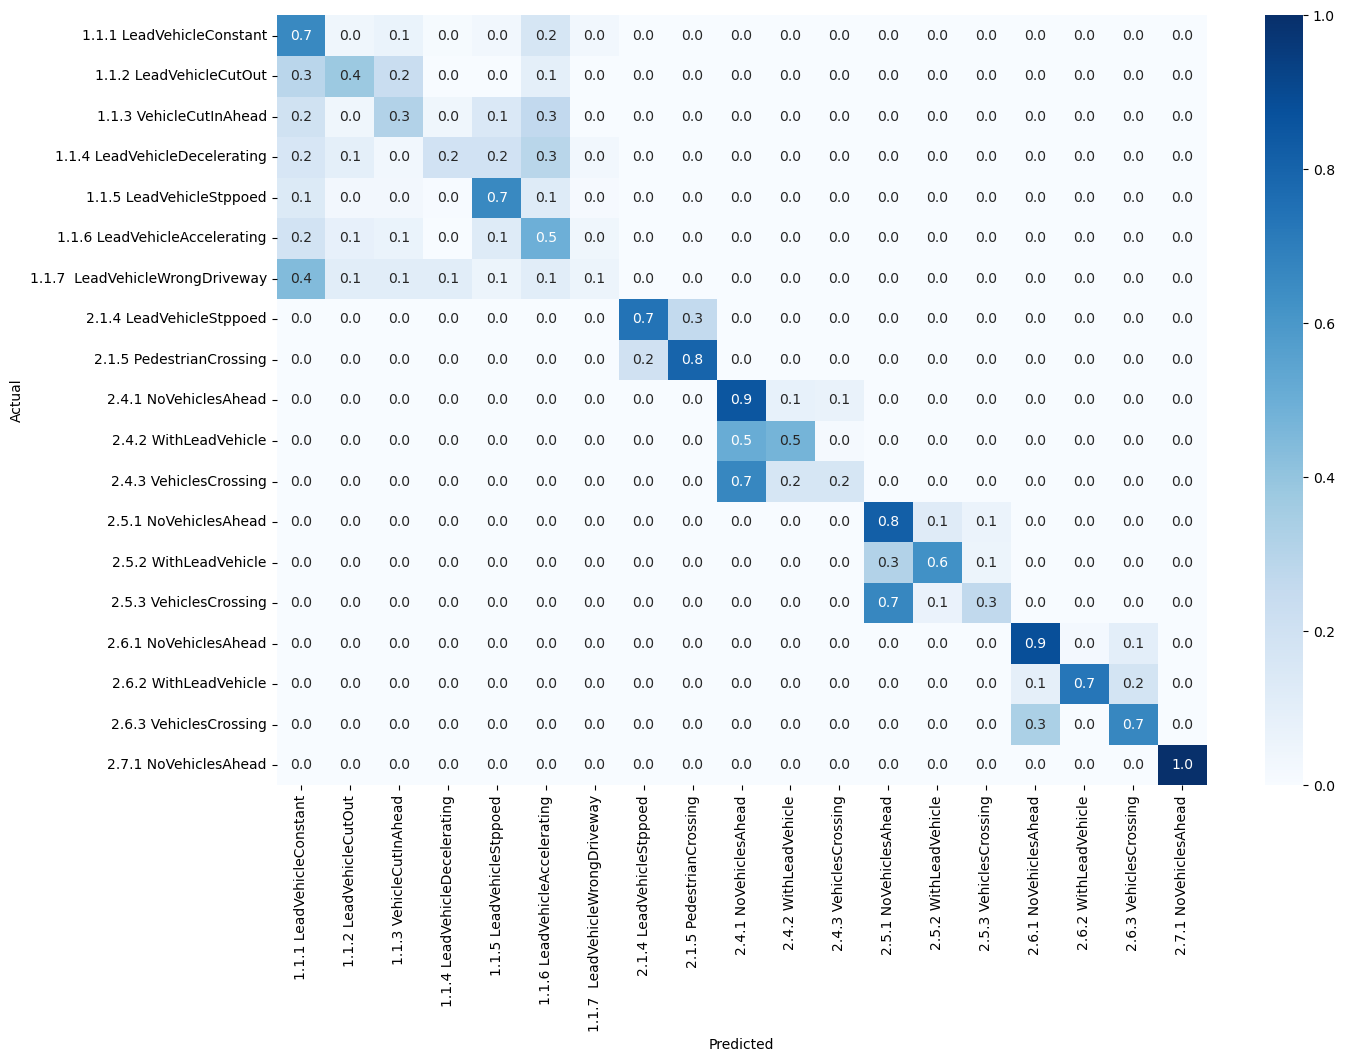

In [425]:
import seaborn as sns
import matplotlib.pyplot as plt

normalized_mat = mat.astype(float) / mat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(15,10))
sns.heatmap(pd.DataFrame(normalized_mat), annot=True, fmt='.1f', cmap='Blues', xticklabels=CONSIDERED_LABELS, yticklabels=CONSIDERED_LABELS)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.savefig('conf.png')

In [428]:
import dtreeviz
# os.environ['PATH'] += os.pathsep + 

# y_train_str = [CONSIDERED_LABELS[i] for i in y_train_encoded]
# y_train_str_unique = list(set(y_train_str))
# y_train_newly_encoded = pd.Series([y_train_str_unique.index(y) for y in y_train])

viz_model = dtreeviz.model(clf,
                           X_train=X_train,
                           y_train=y_train_encoded,
                           feature_names=X_train.columns.tolist(),
                           class_names=CONSIDERED_LABELS,
                           colors=
                          )
                          

v = viz_model.view()
v.save('dtreeviz.svg')

/opt/miniconda3/envs/crat/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


In [376]:
y_train_encoded.min()

0

In [441]:
# df.sort_values(by='lead_tendency_leading_0', ascending=False)[['lead_tendency_leading_0','v_r_leading_0','a_r_leading_0','label']]
df.iloc[2111]['d_yaw_leading_0']

0.0523450622194689